<a href="https://colab.research.google.com/github/Falconwatch/MarketKing/blob/main/Support_resistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке создаётся стратегия на основе точке поддержки и сопротивления
https://medium.datadriveninvestor.com/how-to-detect-support-resistance-levels-and-breakout-using-python-f8b5dac42f21

In [22]:
#!pip install yfinance
#!pip install mplfinance

In [95]:
from numpy.core.numeric import isclose
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

In [96]:
from methods import *

# Готовим данные

In [97]:
stocks = load_data("MSFT", period_start="2021-01-01", step="1d")
stocks = stocks.reset_index()
print(stocks.shape[0])
stocks.head(-5)

[*********************100%***********************]  1 of 1 completed
299


,Date,Open,High,Low,Close,Volume
0,2021-01-04,220.224811,220.689943,212.584781,215.434952,37130100
1,2021-01-05,215.009422,216.256380,213.465584,215.642792,23823000
2,2021-01-06,209.972142,214.247399,209.744529,210.051315,35930700
3,2021-01-07,211.822758,217.067858,211.496190,216.028732,27694500
4,2021-01-08,216.414706,218.295033,214.781804,217.344971,22956200
...,...,...,...,...,...,...
289,2022-02-25,295.140015,297.630005,291.649994,297.309998,32546700
290,2022-02-28,294.309998,299.140015,293.000000,298.790009,34585700
291,2022-03-01,296.399994,299.970001,292.149994,294.950012,31217800
292,2022-03-02,295.359985,301.470001,293.700012,300.190002,31873000


## Размечаем таргет

Размечаем таргет...


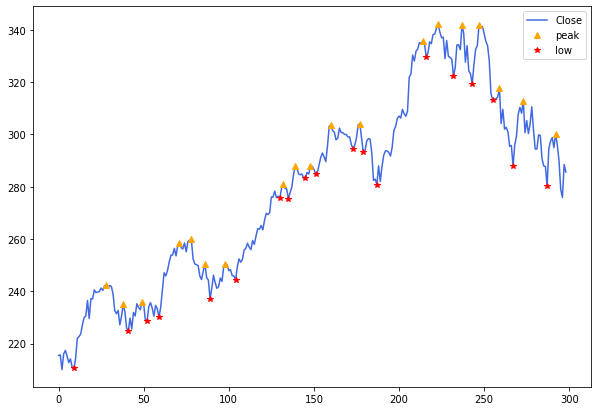

In [98]:
print("Размечаем таргет...")
mark_data_targets(stocks, window=10)

# отрисовываем график таргеты
stocks["Close"].plot(figsize=[10,7], color="royalblue")
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", label="peak", color="orange")
stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", label="low", color="red")

_ = plt.legend()

In [99]:
stocks

,Date,Open,High,Low,Close,Volume,lows,peaks
0,2021-01-04,220.224811,220.689943,212.584781,215.434952,37130100,0.0,0.0
1,2021-01-05,215.009422,216.256380,213.465584,215.642792,23823000,0.0,0.0
2,2021-01-06,209.972142,214.247399,209.744529,210.051315,35930700,0.0,0.0
3,2021-01-07,211.822758,217.067858,211.496190,216.028732,27694500,0.0,0.0
4,2021-01-08,216.414706,218.295033,214.781804,217.344971,22956200,0.0,0.0
...,...,...,...,...,...,...,...,...
294,2022-03-04,294.290009,295.660004,287.170013,289.859985,32356500,0.0,0.0
295,2022-03-07,288.529999,289.690002,278.529999,278.910004,43157200,0.0,0.0
296,2022-03-08,277.799988,283.959991,270.000000,275.850006,48159500,0.0,0.0
297,2022-03-09,283.440002,289.600006,280.779999,288.500000,35204500,0.0,0.0


# Уровни поддержики и сопротивления

## method 1: fractal candlestick pattern

In [100]:
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)

# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)

# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level in levels])==0

In [103]:
df = stocks[["Date",	"Open", "Close",	"High",	"Low", "Volume"]].copy(deep=True)

# a list to store resistance and support levels
levels = []
for i in range(2, df.shape[0] - 2):  
  if is_support(df, i):    
    low = df['Low'][i]    
    if is_far_from_level(low, levels, df):      
      levels.append((i, low))  
  elif is_resistance(df, i):    
    high = df['High'][i]    
    if is_far_from_level(high, levels, df):      
      levels.append((i, high))

In [104]:
# for visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))  
   
  candlestick_ohlc(ax, df.values, width=0.6, colorup='green', 
    colordown='red', alpha=0.8)    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)    
  for level in levels:        
    plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = 
      max(df['Date']), colors='blue', linestyle='--')    
  fig.show()

In [105]:
df.head()

,Date,Open,Close,High,Low,Volume
0,2021-01-04,220.224811,215.434952,220.689943,212.584781,37130100
1,2021-01-05,215.009422,215.642792,216.256380,213.465584,23823000
2,2021-01-06,209.972142,210.051315,214.247399,209.744529,35930700
3,2021-01-07,211.822758,216.028732,217.067858,211.496190,27694500
4,2021-01-08,216.414706,217.344971,218.295033,214.781804,22956200


In [106]:
df.Date = pd.to_datetime(df.Date)
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df["Date"] = df["Date"].apply(mpl_dates.date2num)


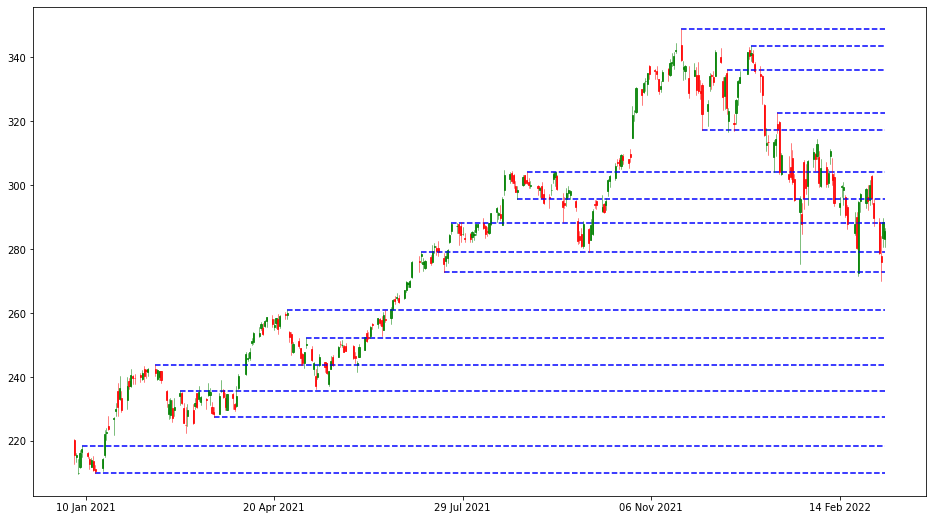

In [107]:
plot_all(levels, df)

# Валидация стратегии

In [ ]:
money_hist_train, money_train, eq_train = validate(train_data, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
2021-01-12 00:00:00: Покупаем 47.0  по цене 212.70355224609375, остаток средств: 2.93304443359375
2021-02-12 00:00:00: Покупаем 0.0  по цене 242.45216369628906, остаток средств: 2.93304443359375
2021-02-18 00:00:00: Покупаем 0.0  по цене 241.8202667236328, остаток средств: 2.93304443359375
2021-02-19 00:00:00: Покупаем 0.0  по цене 239.0230712890625, остаток средств: 2.93304443359375
2021-03-02 00:00:00: Покупаем 0.0  по цене 231.9804229736328, остаток средств: 2.93304443359375
2021-03-03 00:00:00: Покупаем 0.0  по цене 225.7213897705078, остаток средств: 2.93304443359375
2021-03-15 00:00:00: Продаём 47.0  по цене 232.91282653808594, остаток средств: 10949.835891723633
2021-03-17 00:00:00: Покупаем 46.0  по цене 235.12481689453125, остаток средств: 134.0943145751953
2021-03-18 00:00:00: Покупаем 0.0  по цене 228.8558807373047, остаток средств: 134.0943145751953
2021-03-24 00:00:00: Покупаем 0.0  по цене 233.5575714111328, остаток средств: 134.09431457519

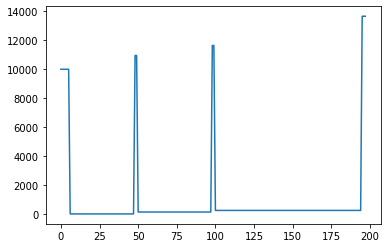

In [ ]:
plt.plot(money_hist_train)

In [ ]:
money_hist_test, money_test, eq_test = validate(test_data, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
2021-10-22 00:00:00: Покупаем 32.0  по цене 307.9586486816406, остаток средств: 145.3232421875
2021-11-09 00:00:00: Покупаем 0.0  по цене 334.6445617675781, остаток средств: 145.3232421875
2021-11-10 00:00:00: Покупаем 0.0  по цене 329.5145568847656, остаток средств: 145.3232421875
2021-11-22 00:00:00: Покупаем 0.0  по цене 339.1287536621094, остаток средств: 145.3232421875
2021-11-23 00:00:00: Покупаем 0.0  по цене 336.98321533203125, остаток средств: 145.3232421875
2021-12-13 00:00:00: Покупаем 0.0  по цене 338.69964599609375, остаток средств: 145.3232421875
2021-12-13 00:00:00: Продаём 32.0  по цене 338.69964599609375, остаток средств: 10983.7119140625
2021-12-14 00:00:00: Покупаем 33.0  по цене 327.6624755859375, остаток средств: 170.8502197265625
2021-12-14 00:00:00: Продаём 33.0  по цене 327.6624755859375, остаток средств: 10983.7119140625
2021-12-30 00:00:00: Покупаем 32.0  по цене 338.6198425292969, остаток средств: 147.876953125
2021-12-31 00:00

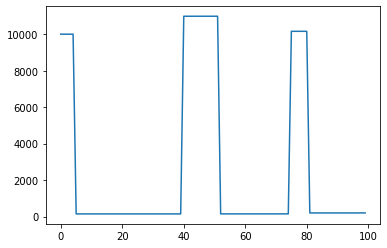

In [ ]:
plt.plot(money_hist_test)